By: Noah Crowley

Case ID: nwc17

#### Changes since discussion

Literally everything after showing the images. All of it is new.

## The Problem

Given a noisy black and white image, I want to be able to remove noise and get close to the original image. I plan to do this using Markov Random Fields and utilizing the pixels immediately surrounding a given pixel. I will include all eight pixels around any given pixel.

## Loading Images

The first step to this is straight-forward - load an image into my program.

To do this, I am using scikit-image. To install this, you can run the following command:

```
pip install scikit-image
```

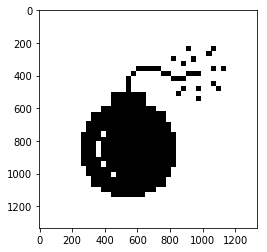

In [100]:
%matplotlib inline

import matplotlib.pyplot as pyplot
from skimage import io as imgio

orig_img = imgio.imread("images/exercise_3_base.png", as_grey = True)
pyplot.imshow(orig_img, cmap = "gray")

### Adding Noise

Now that I have an image, I want to be able to add noise to this image so as to eventually try to remove that noise. Of course, in an actual use-case, the noise would be in the original image. This can again be done in a simple function.

In [60]:
import numpy

def add_noise(image, noise_ratio = 0.1):
    noisy_image = image.copy()
    pixels_to_flip = numpy.random.rand(*noisy_image.shape)
    
    for i in range(len(noisy_image)):
        for j in range(len(noisy_image[i])):
            if pixels_to_flip[i][j] < noise_ratio:
                if noisy_image[i][j] == 255:
                    noisy_image[i][j] = 0
                else:
                    noisy_image[i][j] = 255
    
    return noisy_image

### Showing Images

In order to see results, I will also create a quick function that will show any number of images side-by-side.

In [61]:
def show_images(*args, num_columns = 2):
    pyplot.figure(figsize = (12, 12))
    num_rows = numpy.ceil(len(args) / num_columns)
    subplot_index = num_rows * 100 + num_columns * 10
    
    for i, image in enumerate(args):
        pyplot.subplot(subplot_index + i + 1)
        pyplot.imshow(image, cmap = "gray")

To start, I can now use this method to show the results before and after adding noise to my image.

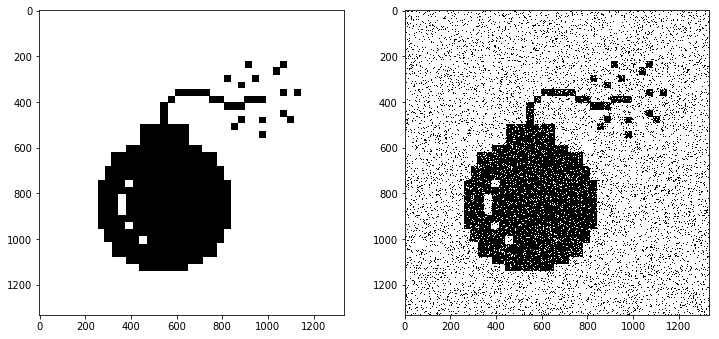

In [62]:
noisy_img = add_noise(orig_img, noise_ratio = 0.1)
show_images(orig_img, noisy_img)

## Removing Noise

Now, in order to remove the noise from this, I will use two methods. The first will use **gradient descent** to optimize the values of the nodes and the second will use **simulated annealing** to slowly decrease the energy allowed in the system, as per my energy functions.

### Converting to the Model

In order to simplify much of the math, the images will need to be transferred from having a range of 0 - 255 per pixel to a range between -1 and 1. A simple function can be used to make this transformation:

In [63]:
def convert_to_model(image):
    model_image = image.copy().astype(numpy.float32)
    
    model_image[model_image >= 0] /= (255 / 2)
    model_image[model_image >= 0] -= 1
    
    return model_image

def convert_back_from_model(model_image):
    normal_image = model_image.copy()
    
    normal_image[normal_image >= -1] += 1
    normal_image[normal_image >= -1] *= (255 / 2)
    normal_image.astype(numpy.int32)
    
    return normal_image

I will also want a noising function for images that are in the model state:

In [64]:
def add_noise_to_model_image(model_image, noise_ratio):
    noisy_model_image = model_image.copy()
    pixels_to_flip = numpy.random.rand(*noisy_model_image.shape)
    
    noisy_model_image[pixels_to_flip < noise_ratio] *= -1
    
    return noisy_model_image

### Analyzing results

In order to actually see the accuracy of the denoising, it will help to have a simple function that returns the ratio of wrong pixels to all pixels (0 is perfect, 1 is exactly backwards).

In [83]:
def calculate_percent_wrong(hiddenimg, resultimg):
    num_wrong = 0
    num_total = 0
    
    for row in range(len(hiddenimg)):
        for col in range(len(hiddenimg[row])):
            num_total += 1
            if hiddenimg[row][col] != resultimg[row][col]:
                num_wrong += 1
                
    return num_wrong/num_total

### The Energy Function

By using a small noise ratio, such as my default 0.1, there will be a strong correlation between the evident i<sup>th</sup> pixel value ($y_i$) and the underlying i<sup>th</sup> pixel value ($x_i$) of the image without noise (hereby known as "original image"). Also, any neighboring pixels in the original image, $x_i$ and $x_j$, must be strongly correlated as they had a purpose to work together to display an image. These two assumptions will provide the foundation for the mathematical model of this denoising process.

The first and most obvious clique that can be drawn from this is the pair $(x_i, y_i)$. The energy function for this can be created by having a positive constant $\eta$ as a weight and combining the three to be $- \eta x_i y_i$. Because $\eta$ is positive, if the signs of $x_i$ and $y_i$ match (they are on the same side of the scale between black and white) then $- \eta x_i y_i$ will be negative, meaning a low value of energy (the goal of the denoising algorithm). However, if $x_i$ and $y_i$ have differring signs (they are on opposite sides of the scale between black and white) then $- \eta x_i y_i$ will be positive, and the denoising algorithm will move to adjust that. Also notice that if they are on opposite sides of the scale between black and white, they may still be very close to the same value and still produce a low energy value, even though it will be positive.

The other cliques will be the pairs of pixels $(x_i, x_j)$ such that the i<sup>th</sup> pixel and the j<sup>th</sup> pixels are next to each other. As before, the resulting energy function should be low whenever they are on the same side of the scale between black and white. They should also have a weighting factor. So, we will call this weighting factor $\beta$, set it to a positive value, and set the energy function for these cliques to be $- \beta x_i x_j$.

Finally, it will be beneficial to have a term that allows us to bias towards black or white. To do this, we can simply sum over all the values of $x_i$ and multiply this sum by another positive constant. I will call this term $\alpha$.

So, the resulting energy function given a base image X and a noised image Y is as such:

$$
E(X,Y) = \alpha \sum_{i}x_i - \beta \sum_{i,j}x_i x_j - \eta \sum_{i}x_i y_i
$$

A very simple and easy improvement to this can be seen in the $\beta$ piece. Computationally, the piece alone is O(5N), which isn't horribly inefficient but could stand to be improved. A simple way to do this is to use convolutions and utilize the power of matrices. Since I am using all eight surrounding pixels, I can create a 3x3 matrix with 1 in every value except the center (1,1) position. That is:

$$
\beta_m = \left[ {\begin{array}{rrr} 
1 & 1 & 1\\
1 & 0 & 1\\
1 & 1 & 1
\end{array} } \right]
$$

Now, to put this into code form, I will create a function that takes in a hidden image (in the model form), an observation image, and values for each of my three weighting variables $(\eta, \beta, \alpha)$.

In [65]:
from scipy.signal import convolve2d as conv2d

def energy_function(hiddenimg, observedimg, eta, beta, alpha):
    beta_matrix = numpy.asarray([[1, 1, 1], [1, 0, 1], [1, 1, 1]])
    convolution_result = conv2d(hiddenimg, beta_matrix, 'same')
    energy_map = hiddenimg * (alpha - beta*convolution_result - eta*observedimg)
    energy = numpy.mean(energy_map)
    return energy

### Gradient Descent

One method that I will employ to denoise the image will be gradient descent. That is, I will compute the gradient of the energy function and attempt to move down toward the correct image by adjusting pixels as I go. For every pixel flip (on pixel $x_k$), I can say the resulting image is $X^\prime$ and compute the energy function of that:

$$
\begin{align}
E(X^\prime, Y) & = \alpha(\sum_{i}x_i - 2x_k) - \beta(\sum_{i,j}x_i x_j - \sum_{j}2 x_k x_j) - \eta(\sum_{i}x_i y_i - 2 x_k y_k)\\
               & = E(X, Y) - 2 x_k (\alpha - \beta \sum_{j} x_k x_j - \eta y_k)
\end{align}
$$

So then, my gradient $\nabla E$ is:

$$
\nabla E = -2 x_k (\alpha - \beta \sum_{j} x_k x_j - \eta y_k)
$$

The first issue is getting this gradient. Making a small change to my energy function so that it computes the gradient at the same time seems easiest. I'll create a new function for this purpose.

In [66]:
def energy_function_with_gradient(hiddenimg, observedimg, eta, beta, alpha):
    beta_matrix = numpy.asarray([[1, 1, 1], [1, 0, 1], [1, 1, 1]])
    convolution_result = conv2d(hiddenimg, beta_matrix, 'same')
    energy_map = hiddenimg * (alpha - beta*convolution_result - eta*observedimg)
    energy = numpy.mean(energy_map)
    energy_gradient = -2 * energy_map
    
    return energy, energy_gradient

Now I need to actually create the function to iterate and make this gradient descent happen. For this, I will simply need a while loop that continues until I eventually stop making progress.

In [67]:
def denoise_with_gradient_descent(observedimg):
    resultimg = observedimg.copy()
    
    energy, energy_gradient = energy_function_with_gradient(resultimg, observedimg, 1, 1, 1)
    
    prev_energy = energy + 1
    
    while prev_energy > energy:
        prev_energy = energy #Now set previous energy to existing energy
        resultimg[energy_gradient < 0] *= -1 #Flip all pixels the gradient says are off
        energy, energy_gradient = energy_function_with_gradient(resultimg, observedimg, 1, 1, 1) #Compute new energy function
    
    return resultimg

#### Testing the results

Now that the code is all prepared, it is time to see what happens!

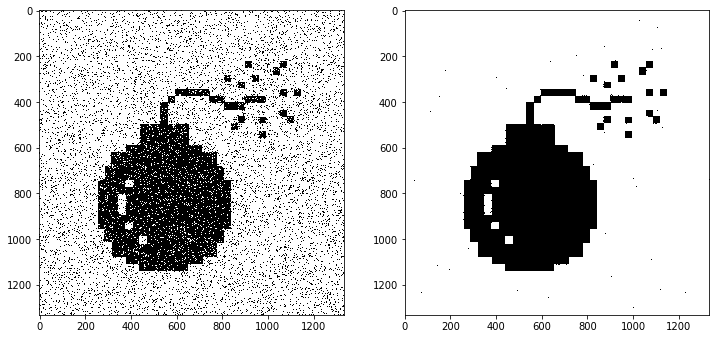

In [90]:
gd_noisy_model_img = convert_to_model(noisy_img)
gd_denoised_model_img = denoise_with_gradient_descent(gd_noisy_model_img)
gd_denoised_img = convert_back_from_model(gd_denoised_model_img)
show_images(noisy_img, gd_denoised_img)

While looking at the image already tells most of the story, it also helps to know the actual percentage of incorrect pixels:

In [98]:
print("Percent of pixels incorrect: %.2f%%" % (calculate_percent_wrong(orig_img, gd_denoised_img)*10))

Percent of pixels incorrect: 0.01%


### Simulated Annealing

Another method I will employ to attack this problem is simulated annealing. The method itself is simple:

 - Go through N neighbors of the current image state and calculate the energy of this image
   - For each neighbor, check if the energy is better, and if so, switch to that. If not, then there is a probability (T) that I will switch to it.
   - To get to a neighbor, I can use my *add_noise_to_model_image* function from before
 - Repeat

The hard part is deciding when to stop.

For this, I will simply have two cutoffs - if the energy function drops below a given value or if I hit some given number of iterations.

Putting this into code is rather simple:

In [103]:
import random

def denoise_with_simulated_annealing(observedimg, cost_function, cost_cutoff = -7.5, iterations_cutoff = 10, neighbors_per_iteration = 50, noise_ratio_for_neighbors = 0.05):
    resultimg = observedimg.copy()
    result_cost = numpy.sum(observedimg)
    
    tempimg = observedimg.copy()
    temp_cost = cost_cutoff + 1
    
    iterations = 0
    
    while temp_cost > cost_cutoff and iterations < iterations_cutoff:
        iterations += 1
        
        for n in range(neighbors_per_iteration):
            newimg = add_noise_to_model_image(tempimg, noise_ratio_for_neighbors)
            new_cost = cost_function(newimg, observedimg)
            
            if new_cost < temp_cost:
                tempimg = newimg
                temp_cost = new_cost
            else:
                T = 1 - (iterations/iterations_cutoff)
                r = random.uniform(0, 1)
                if (r < T):
                    tempimg = newimg
                    temp_cost = new_cost
                    
            if new_cost < result_cost:
                resultimg = newimg
                result_cost = new_cost
                
    return resultimg

#### Testing the results

Now that the code is ready, let's see what happens!

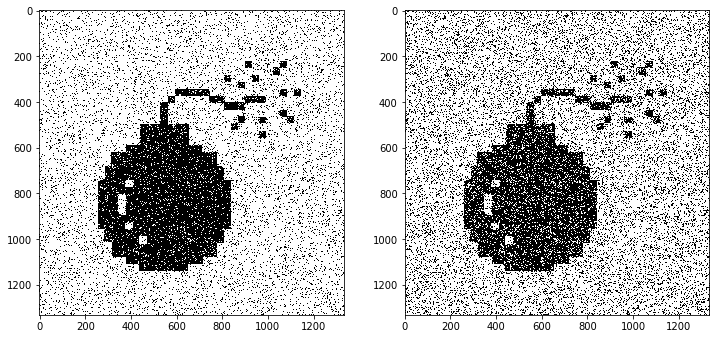

In [101]:
def cost_function(hiddenimg, observedimg):
    return energy_function(hiddenimg, observedimg, 1, 1, 1)

sa_noisy_model_img = convert_to_model(noisy_img)
sa_denoised_model_img = denoise_with_simulated_annealing(sa_noisy_model_img, cost_function, noise_ratio_for_neighbors = 0.1)
sa_denoised_img = convert_back_from_model(sa_denoised_model_img)
show_images(noisy_img, sa_denoised_img)

While looking at the image already tells most of the story, it also helps to know the actual percentage of incorrect pixels:

In [102]:
print("Percent of pixels incorrect: %.2f%%" % (calculate_percent_wrong(orig_img, sa_denoised_img)*10))

Percent of pixels incorrect: 1.79%


# Conclusion

After all of this, it appears that gradient descent has worked far better in this problem - by two orders of magnitude! Additionally, the gradient descent also ran much faster.

For this problem, with this sort of model, gradient descent reigns supreme.